<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula03c_multiclasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetBidimensionalMulticlasse(n=20, n_classes=3):
    """
    Cria um dataset bidimensional multiclasse.
    """
    X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0, 1.0), cluster_std=0.02)
    return X, y

n_classes = 4
X, y = criaDatasetBidimensionalMulticlasse(1000, n_classes)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

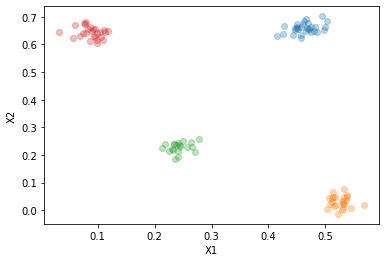

In [44]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

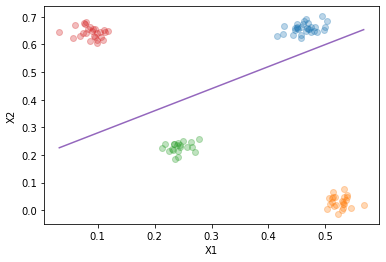

In [45]:
def plotaHiperplanoDatasetBidimensional(X, vetor, intercept=0):
    """
    Plota um definido por um
    vetor e o valor em que este vetor 
    intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array([4, 5]) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, vetor_hyperplano, 1)

In [46]:
def sign(a):
    return (a >= 0) * 2 - 1

def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [47]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [48]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05, 
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

1.0
[[-10.50321314  -1.89339383   4.74717979  -1.31851337]
 [ 12.90774206   9.50205314 -11.02907613 -15.72434357]
 [ 10.57330395 -12.71285044  -8.59159628   8.18515846]]


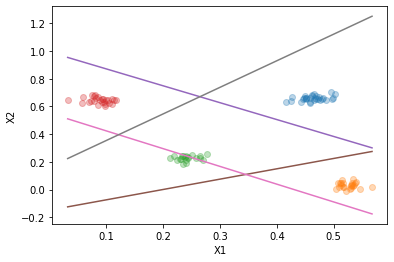

In [49]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)

if perceptron.w.shape[1] == 1:
  plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
else:
  for i in range(perceptron.w.shape[1]):
    plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])

0.98 0.9755555555555555
[[-2.79076049 -0.13023     0.5805678   0.3450241 ]
 [ 3.65518158  1.49205878 -1.76236302 -3.39361519]
 [ 2.78940395 -2.12986318 -1.41379015  0.75049653]]


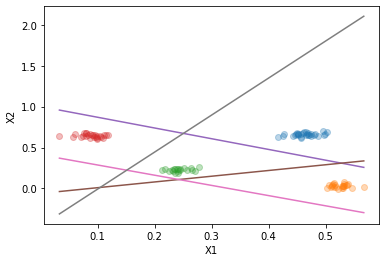

1.0 1.0
[[-1.20884972 -0.0563993   0.50142343  0.11465738]
 [ 0.96388599  0.32332459 -1.05294187 -1.47078651]
 [ 1.30932943 -1.21822778 -0.78044729  0.67490771]]


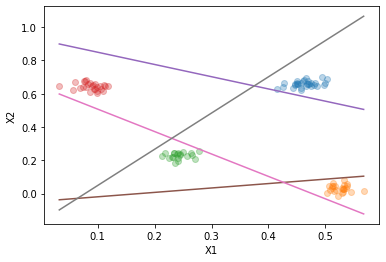

1.0 0.9988888888888889
[[-4.26619235 -0.8894509   0.14367904 -0.3472938 ]
 [ 5.2966148   4.02517907 -2.08785175 -6.36488588]
 [ 4.02475118 -4.81819427 -1.57107074  3.23121744]]


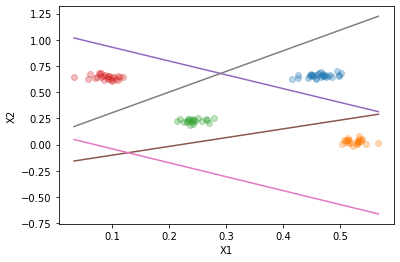

1.0 1.0
[[-4.90896078 -0.70449939  1.04929083 -1.0957645 ]
 [ 4.90952572  4.29714971 -3.64016385 -7.27983917]
 [ 5.25258588 -7.28692864 -3.59340074  4.16635095]]


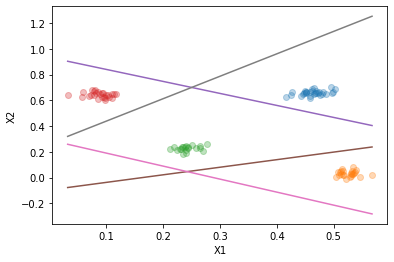

In [54]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    perceptron = Perceptron(training_algorithm=DescidaGradiente(learning_rate=0.01, regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)))
    print(perceptron.w)
    plotaDatasetBidimensional(Xtr, ytr)
    if perceptron.w.shape[1] == 1:
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
    else:
        for i in range(perceptron.w.shape[1]):
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])
    plt.show()